## Load Modules

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy.io.wavfile
import os
import math
import matplotlib
import scipy.stats

from librosa.display import *
from librosa.effects import *
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
os.chdir('/users/hyunwoogu/Dropbox/2018MARG/Emotion Recognition/')

In [11]:
os.chdir('./Emotional Speech Recognition/')

In [13]:
os.chdir('./GAN_generation/Samples/')

In [14]:
lists = []
for wave in os.listdir(os.getcwd()):
    if "wav" in wave:
        lists.append(wave)
        
res = []

for wave in lists:
    data, fs = librosa.load(wave)
    data = data/np.ptp(data)
    res.append(data.shape[0])

In [15]:
def onset(data):
    cnt = 0  
    for i in data:
        cnt += 1
        if i > 1e-2:
            return(data[(cnt-1):])
            break
            
def termin(data):
    cnt = 0
    for i in reversed(data):
        cnt += 1
        if i > 1e-2:
            return(data[:(len(data)-cnt+1)])
            break

## Construction of Dataset

In [16]:
foo = 'Sad'
bar = 'Happy'

ListSad   = np.array(lists)[[i for i, v in enumerate(lists) if foo in v]]
ListHappy = np.array(lists)[[i for i, v in enumerate(lists) if bar in v]]

Happy_M = np.zeros([129, 410])
Happy_P = np.zeros([129, 410])
Sad_M   = np.zeros([129, 410])
Sad_P   = np.zeros([129, 410])

In [17]:
for wave in ListHappy:
    data, fs = librosa.load(wave)
    trimmed = onset(data)
    trimmed = termin(trimmed)

    trimmed = librosa.effects.time_stretch(trimmed, len(trimmed)/ fs / 1.5)

    STFT    = librosa.stft(trimmed, n_fft=256, hop_length=int(0.01 * 8000), window='hann')
    M, P    = librosa.magphase(STFT)
    logM    = np.log(M)
            
    Happy_M = np.vstack((Happy_M, logM))
    Happy_P = np.vstack((Happy_P, P))    
        
HappyX = np.reshape(Happy_M, [ListHappy.shape[0]+1, 129, 410])
HappyX = HappyX[1:, :, :]
HappyP = np.reshape(Happy_P, [ListHappy.shape[0]+1, 129, 410])
HappyP = HappyP[1:, :, :]

In [19]:
for wave in ListSad:
    data, fs = librosa.load(wave)
    trimmed = onset(data)
    trimmed = termin(trimmed)

    trimmed = librosa.effects.time_stretch(trimmed, len(trimmed)/ fs / 1.5)

    STFT    = librosa.stft(trimmed, n_fft=256, hop_length=int(0.01 * 8000), window='hann')
    M, P    = librosa.magphase(STFT)
    logM    = np.log(M)
            
    Sad_M = np.vstack((Sad_M, logM))
    Sad_P = np.vstack((Sad_P, P))    
        
SadX = np.reshape(Sad_M, [ListSad.shape[0]+1, 129, 410])
SadX = SadX[1:, :, :]
SadP = np.reshape(Sad_P, [ListSad.shape[0]+1, 129, 410])
SadP = SadP[1:, :, :]

In [20]:
dataX = np.vstack((HappyX, SadX))
dataX = np.reshape(dataX, [9, 129, 410])
dataY = np.repeat(np.array([1, 0]), [5, 4])

CheckX = np.vstack((HappyP, SadP))
CheckX = np.reshape(CheckX, [9, 129, 410])
CheckY = np.repeat(np.array([1, 0]), [9, 400])

In [21]:
inx = np.array(range(9))
np.random.shuffle(inx)

dataX = dataX[inx, :, :]
dataY = dataY[inx]

CheckX = CheckX[inx, :, :]
CheckY = CheckY[inx]

dataY = to_categorical(dataY, 2)

## Hyperparameters

In [53]:
total_epoch = 300
batch_size  = 9
n_hidden = 512
n_input  = 129 * 410
n_noise  = 256
n_class  = 2

## Model

In [54]:
tf.reset_default_graph()

In [55]:
X = tf.placeholder(tf.float32, [None, n_input])
Y = tf.placeholder(tf.float32, [None, n_class])
Z = tf.placeholder(tf.float32, [None, n_noise])

In [56]:
def generator(noise, labels):
    with tf.variable_scope('generator'):
        inputs = tf.concat([noise, labels], 1)
        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, n_input,
                                 activation=tf.nn.sigmoid)

    return output


def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        if reuse:
            scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden,
                                 activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1,
                                 activation=None)

    return output


def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

## Loss Function

In [57]:
G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

loss_D_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.zeros_like(D_gene)))

loss_D = loss_D_real + loss_D_gene
loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_gene, labels=tf.ones_like(D_gene)))


vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list=vars_G)

## Train!

In [58]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(9/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs = np.reshape(dataX[batch_size*i:batch_size*(i+1), :, :], [batch_size, n_input])
        batch_ys = np.reshape(dataY[batch_size*i:batch_size*(i+1), :], [batch_size, 2])
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 2
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Y: dataY[[2,0], :], Z: noise}) ## 0, 1

print('Optimization Completed!')

Epoch: 0000 D loss: 0.5996 G loss: 323.5
Epoch: 0001 D loss: 0.0 G loss: 515.1
Epoch: 0002 D loss: 0.0 G loss: 644.3
Epoch: 0003 D loss: 0.0 G loss: 732.5
Epoch: 0004 D loss: 0.0 G loss: 780.1
Epoch: 0005 D loss: 0.0 G loss: 806.8
Epoch: 0006 D loss: 0.0 G loss: 847.5
Epoch: 0007 D loss: 0.0 G loss: 835.6
Epoch: 0008 D loss: 0.0 G loss: 847.6
Epoch: 0009 D loss: 0.0 G loss: 842.6
Epoch: 0010 D loss: 0.0 G loss: 775.0
Epoch: 0011 D loss: 0.0 G loss: 767.0
Epoch: 0012 D loss: 0.0 G loss: 686.2
Epoch: 0013 D loss: 0.0 G loss: 674.4
Epoch: 0014 D loss: 0.0 G loss: 673.8
Epoch: 0015 D loss: 0.0 G loss: 596.4
Epoch: 0016 D loss: 0.0 G loss: 576.7
Epoch: 0017 D loss: 0.0 G loss: 476.4
Epoch: 0018 D loss: 0.0 G loss: 488.5
Epoch: 0019 D loss: 0.0 G loss: 463.4
Epoch: 0020 D loss: 0.0 G loss: 388.6
Epoch: 0021 D loss: 0.0 G loss: 324.8
Epoch: 0022 D loss: 0.0 G loss: 346.6
Epoch: 0023 D loss: 0.0 G loss: 293.6
Epoch: 0024 D loss: 0.0 G loss: 249.1
Epoch: 0025 D loss: 0.0 G loss: 232.8
Epoch: 00

## Results

In [137]:
res = np.reshape(samples, [2, 129, 410])

In [72]:
#res0 = librosa.decompose.nn_filter(np.exp(res[0, :, :]), aggregate=np.median, metric='cosine') * CheckX[2, :, :]
#res1 = librosa.decompose.nn_filter(np.exp(res[1, :, :]), aggregate=np.median, metric='cosine') * CheckX[0, :, :]

res0 = np.exp(dataX[3, :, :]) * CheckX[2, :, :]
res1 = np.exp(dataX[4, :, :]) * CheckX[0, :, :]

res0 = librosa.istft(res0, hop_length=int(0.01 * 8000), window='hann')
res1 = librosa.istft(res1, hop_length=int(0.01 * 8000), window='hann')

res0 = librosa.effects.time_stretch(res0, len(res0)/ fs / 2)
res1 = librosa.effects.time_stretch(res1, len(res1)/ fs / 2)

librosa.output.write_wav('Original1.wav',   res0, fs)
librosa.output.write_wav('Original2.wav', res1, fs)

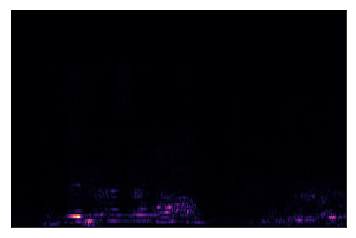

In [29]:
specshow(np.exp(dataX[8, :, :]), sr=fs)

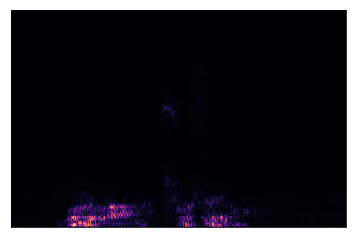

In [73]:
specshow(np.exp(dataX[3, :, :]), sr=fs)

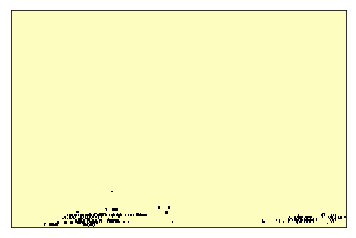

In [148]:
specshow(NoiseReducer(np.exp(res[0])))

In [159]:
def NoiseReducer(data):
    foo = np.exp(data)
    bar = np.percentile(np.ndarray.flatten(foo), 0.9)

    for i in range(129):
        for j in range(410):
            if foo[i, j] <= bar:
                foo[i, j] = 0.0
    
    return(foo)

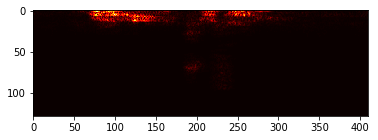

In [76]:
plt.imshow(np.exp(dataX[3, :, :]), cmap='hot', interpolation='nearest')
plt.show()

In [156]:
np.exp(dataX[3, :, :])[100, 400]

4.5426911650557713e-05

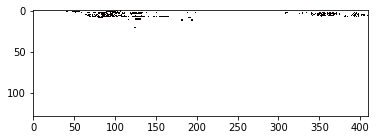

In [160]:
plt.imshow(NoiseReducer(np.exp(res[0])) + 1e-04, cmap='hot', interpolation='nearest')
plt.show()

In [145]:
res0 = NoiseReducer(np.exp(res[0])) * CheckX[2, :, :]
res1 = NoiseReducer(np.exp(res[1])) * CheckX[0, :, :]

res0 = librosa.istft(res0, hop_length=int(0.01 * 8000), window='hann')
res1 = librosa.istft(res1, hop_length=int(0.01 * 8000), window='hann')

res0 = librosa.effects.time_stretch(res0, len(res0)/ fs / 2)
res1 = librosa.effects.time_stretch(res1, len(res1)/ fs / 2)

librosa.output.write_wav('Original3.wav', res0, fs)
librosa.output.write_wav('Original4.wav', res1, fs)

In [161]:
data, fs = librosa.load('generated.wav')
data = librosa.effects.time_stretch(data, len(data)/ fs )

librosa.output.write_wav('G.wav', data, fs)